#### Import necessary libraries:

In [1]:
#Pandas:

import pandas as pd
from pandas import option_context
from time import time

#Numpy, matplotlib & astropy:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import random
from astropy.table import Table
import PlottingStyle #Author-defined 

#PAHdbPythonSuite:
import pkg_resources
from pkg_resources import resource_filename
from AmesPAHdbPythonSuite.amespahdbpythonsuite.amespahdb import AmesPAHdb
from AmesPAHdbPythonSuite.amespahdbpythonsuite.xmlparser import XMLparser
from AmesPAHdbPythonSuite.amespahdbpythonsuite import observation


#Import modules from scikit-learn:

# For data scaling:
from sklearn.preprocessing import *

# Pipeline, Grid Search, train_test_split, Cross-Validation: 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV

#Classifiers & Metrics:
from sklearn.metrics import *
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

#Imbalanced-learn library:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


>## <span style='color:DarkBlue'> I. Data Collection:  </span> Importing the PAHdb theoretical database


In [4]:
#Path to database to be read using the amespahdbpythonsuite package:

path = '../../pahdb-complete-theoretical-v3.20_X3N8UL.xml'

#XML Parser:
xml = pkg_resources.resource_filename('amespahdbpythonsuite', path)
parser = XMLparser(xml)
parser.verify_schema()
library = parser.to_pahdb_dict()


# Parsing the database using the AmesPAHdbPythonSuite:
db = AmesPAHdb(filename=resource_filename('amespahdbpythonsuite', path),
                  check=False, cache=False)

                 AmesPAHdbPythonSuite
                 
                          by
                          
                Dr. Christiaan Boersma
                
                          and
                         
             Dr. Alexandros Maragkoudakis
             
               Dr. Matthew J. Shannanon
               
                  Dr. Joseph E. Roser
                 

          SUITE VERSION: 0.5.0.post35+g5802e6c         

        WEBSITE: HTTP://WWW.ASTROCHEM.ORG/PAHDB/       

          CONTACT: CHRISTIAAN.BOERSMA@NASA.GOV         

     PARSING DATABASE: THIS MAY TAKE A FEW MINUTES     

==
FILENAME                    : /var/folders/x8/ygh87n3s68533f00f05nx66c0000gn/T/78624c928c233c02e0089b08fec85f32.pkl
PARSE TIME                  : 0:00:11.980027
VERSION (DATE)              : 3.20 (2019-09-12)
COMMENT                     : 

This is the NASA Ames PAH IR Spectroscopic Database. The contents of
the database are described in Bauschlicher et al. (2010), Boersma 

In [5]:
#Information available:
library['species'][430].keys()

dict_keys(['comments', 'references', 'geometry', 'transitions', 'laboratory', 'formula', 'charge', 'symmetry', 'weight', 'total_e', 'vib_e', 'method', 'n_solo', 'n_duo', 'n_trio', 'n_quartet', 'n_quintet', 'n_ch2', 'n_chx'])

>## <span style='color:DarkBlue'> II. Data Preparation:  </span> Extracting relevant features for analysis

Selection criteria: Selecting "astronomically relevant" PAH species i..e those that have atleast 20 Carbon atoms and are either a "pure" PAH or <br> PANH and have neither any aliphatic side group groups nor O, Mg, Si or Fe atoms. The final dataframe built has the following features: <br>

Specie UID, Charge, Charge State, Size (No. of C atoms), solos, duos, trios, quartets, $s/N_{H}$, $d/N_H$, $t/N_H$, $q/N_H$, $A_{11.2}$, $A_{12.0}$, $A_{12.7}$, $A_{13.5}$.

In [9]:
#Unique identifiers of PAH species that satisy the selection criteria are fetched using the database parser: 
specie_uids = db.search("h>0 c>20 ch2=0 chx=0 oxygen=0 magnesium=0 silicium=0 iron=0")

#Build the data catalog: 

#Charges:
charges  = [library['species'][specie_uid]['charge'] for specie_uid in specie_uids]

#No. of C atoms indicating size:
n_C = [float(library['species'][specie_uid]['formula'][1:library['species'][specie_uid]['formula'].index('H')]) for specie_uid in specie_uids]

#Electronic Transitions - information from stick spectra:
transitions  = [library['species'][specie_uid]['transitions'] for specie_uid in specie_uids]
frequencies = [[i['frequency'] for i in specie_trans] for specie_trans in transitions] #[1/cm]
intensities = np.array([np.array([(i['intensity']) for i in specie_trans]) for specie_trans in transitions], dtype=object) #[km / mol]
wavelengths = [(1/(np.array(frequency_lst) + 15.)) * 10000 for frequency_lst in frequencies] #from [cm^-1 to [μm]. 
#A redshift of 15 cm^-1 has been applied to account for the wavelength shift between emission and absorption process.
#Discussed in Section 3 in Bauschlicher, Peeters, Allamandola (2009).

#No. of Solo, duo, trio or quartet groups in the molecules:
n_solo = np.array([library['species'][specie_uid]['n_solo']/1. for specie_uid in specie_uids])
n_duo = np.array([library['species'][specie_uid]['n_duo']/2. for specie_uid in specie_uids])
n_trio = np.array([library['species'][specie_uid]['n_trio']/3. for specie_uid in specie_uids])
n_quartet = np.array([library['species'][specie_uid]['n_quartet']/4. for specie_uid in specie_uids])
n_quintet = np.array([library['species'][specie_uid]['n_quintet']/5. for specie_uid in specie_uids]) #Actually all zero..

#Total no. of H atoms:
n_H =n_solo + n_duo + n_trio + n_quartet + n_quintet


In [16]:
#Preparing the Pandas dataframe with the necessary data:


d = {'Specie_UID': specie_uids, 'Charge': charges, "Charge state": np.zeros(len(charges)), 'Size ($N_C$)': n_C, 'Wavelengths':wavelengths,
     'A': intensities,\
     'solos': n_solo, 'duos': n_duo, 'trios': n_trio, 'quartets': n_quartet, \
     '$s/N_{H}$': n_solo/n_H, '$d/N_{H}$': n_duo/n_H,  '$t/N_{H}$': n_trio/n_H,
     '$q/N_{H}$': n_quartet/n_H}
df = pd.DataFrame(data=d)

#Assigning anion/cation/neutral designations:

df.loc[df.Charge == 0, 'Charge state'] = 'Neutral'
df.loc[df.Charge > 0, 'Charge state'] = 'Cation'
df.loc[df.Charge < 0, 'Charge state'] = 'Anion'

pd.set_option('display.max_colwidth', 10)
pd.set_option('display.precision', 2)

df.head()


,Specie_UID,Charge,Charge state,Size ($N_C$),Wavelengths,A,solos,duos,trios,quartets,$s/N_{H}$,$d/N_{H}$,$t/N_{H}$,$q/N_{H}$
0,2354,0,Neutral,21.0,[140.6...,[0.121...,2.0,0.0,1.0,2.0,0.4,0.0,0.20,0.40
1,2353,0,Neutral,21.0,[105.4...,[0.127...,2.0,0.0,1.0,2.0,0.4,0.0,0.20,0.40
2,2352,0,Neutral,21.0,[173.3...,[0.154...,2.0,0.0,1.0,2.0,0.4,0.0,0.20,0.40
3,2351,0,Neutral,21.0,[142.3...,[0.193...,1.0,1.0,2.0,1.0,0.2,0.2,0.40,0.20
4,2350,0,Neutral,21.0,[166.0...,[0.141...,3.0,0.0,2.0,1.0,0.5,0.0,0.33,0.17


In [18]:
#Truncating the wavelengths of transitions to the 10-15μm range:

for mol in range(len(df)):
    wave_10_15_micron = []
    abs_10_15_micron = []

    for wave,abs_coeff in zip(df.iloc[mol]['Wavelengths'],df.iloc[mol]['A']):
        if wave > 10. and wave < 15.:
            wave_10_15_micron.append(wave)
            abs_10_15_micron.append(abs_coeff)
            
    if len(wave_10_15_micron) > 0:
        df.at[mol,'Wavelengths'] = np.sort(wave_10_15_micron)
        df.at[mol,'A'] = np.array(abs_10_15_micron)[np.argsort(wave_10_15_micron)]

        
    else:
        df.at[mol,'Wavelengths'] = np.nan
        df.at[mol,'A'] = np.nan

        #It was later confirmed that each molecule had transitions in the 10-15μm eg. through: df[df.isna().any(axis=1)]


In [19]:
#Adding columns of A-values [related to average absorption cross-sections] in four wavelength regions:

df["$A_{11.2}$"],df["$A_{12.0}$"], df["$A_{12.7}$"], df["$A_{13.5}$"] = [[np.nan]*len(df) for i in range(4)]

## Determining average A-values at particular wavelength regions and adding to the dataframe:

wave_reg1 = [10.6, 11.4]
wave_reg2 = [11.35, 12.8]
wave_reg3 = [12.5, 13.3]
wave_reg4 = [13.0, 13.9]

for mol in range(len(df)):
    s1,s2,s3,s4 =  [0 for i in range(4)]

    waves = df.iloc[mol]['Wavelengths']
    A_vals = df.iloc[mol]['A']
 
    for i in range(len(waves)):
        wave = waves[i]
        A_val = A_vals[i]
        if wave >= wave_reg1[0] and wave <= wave_reg1[1]:
            s1 += A_val
        elif wave >= wave_reg2[0] and wave <= wave_reg2[1]:
            s2 += A_val
        elif wave >= wave_reg3[0] and wave <= wave_reg3[1]:
            s3 += A_val
        elif wave >= wave_reg4[0] and wave <= wave_reg4[1]:
            s4 += A_val
        
    if s1 != 0.:
        df.at[mol,"$A_{11.2}$"] = s1
    if s2 != 0.:
        df.at[mol,'$A_{12.0}$'] = s2
    if s3 != 0.:
        df.at[mol,'$A_{12.7}$'] = s3
    if s4 != 0.:
        df.at[mol,'$A_{13.5}$'] = s4

#Drop rows with NaN values:
df = df.dropna().reset_index(drop=True)
df.head()


,Specie_UID,Charge,Charge state,Size ($N_C$),Wavelengths,A,solos,duos,trios,quartets,$s/N_{H}$,$d/N_{H}$,$t/N_{H}$,$q/N_{H}$,$A_{11.2}$,$A_{12.0}$,$A_{12.7}$,$A_{13.5}$
0,2354,0,Neutral,21.0,[10.02...,[0.042...,2.0,0.0,1.0,2.0,0.40,0.0,0.2,0.40,23.82,51.15,64.33,49.86
1,2353,0,Neutral,21.0,[10.02...,[0.474...,2.0,0.0,1.0,2.0,0.40,0.0,0.2,0.40,42.63,45.78,69.65,21.93
2,2352,0,Neutral,21.0,[10.05...,[0.013...,2.0,0.0,1.0,2.0,0.40,0.0,0.2,0.40,28.94,24.00,111.67,34.15
3,2349,0,Neutral,21.0,[10.00...,[0.040...,1.0,1.0,2.0,1.0,0.20,0.2,0.4,0.20,3.34,124.73,61.62,10.51
4,833,0,Neutral,21.0,[10.02...,[0.319...,1.0,0.0,0.0,3.0,0.25,0.0,0.0,0.75,13.97,85.72,19.71,34.67


>## <span style='color:DarkBlue'> III. Data Exploration:  </span> 

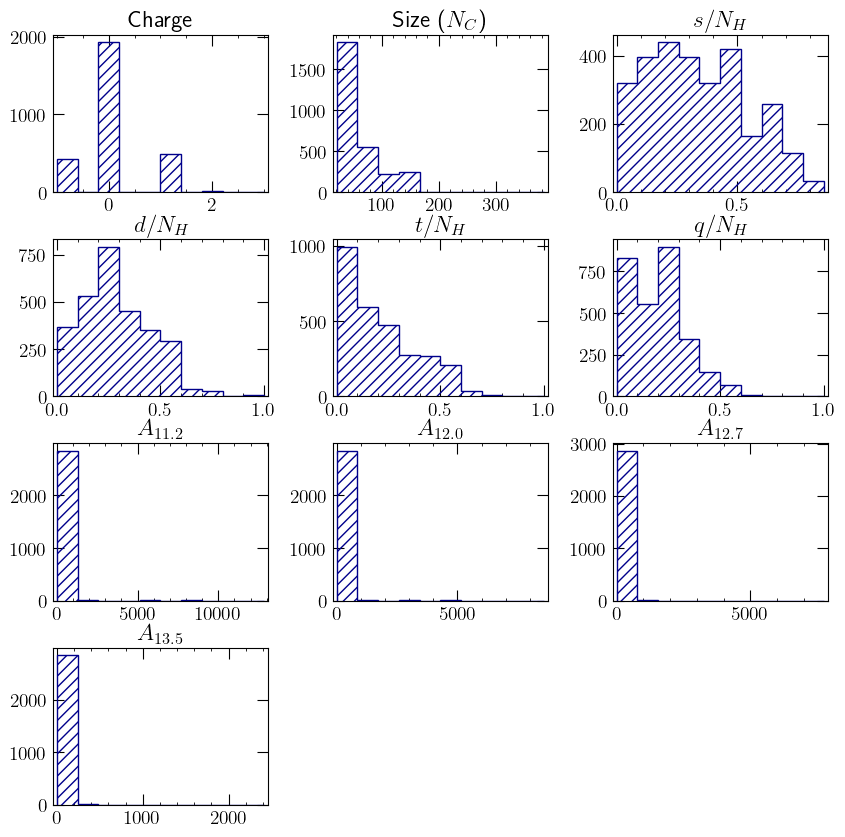

In [20]:
#Histogram of relevant features:

cols = ['Charge', 'Size ($N_C$)', '$s/N_{H}$', '$d/N_{H}$', '$t/N_{H}$', '$q/N_{H}$',\
                  '$A_{11.2}$',  '$A_{12.0}$',  '$A_{12.7}$', '$A_{13.5}$']
df.hist(grid = False, figsize = (10,10), histtype='step', hatch='///', color = 'darkblue', 
        column = cols);
plt.savefig("Plots/DataStats_Hist.png", dpi = 200)

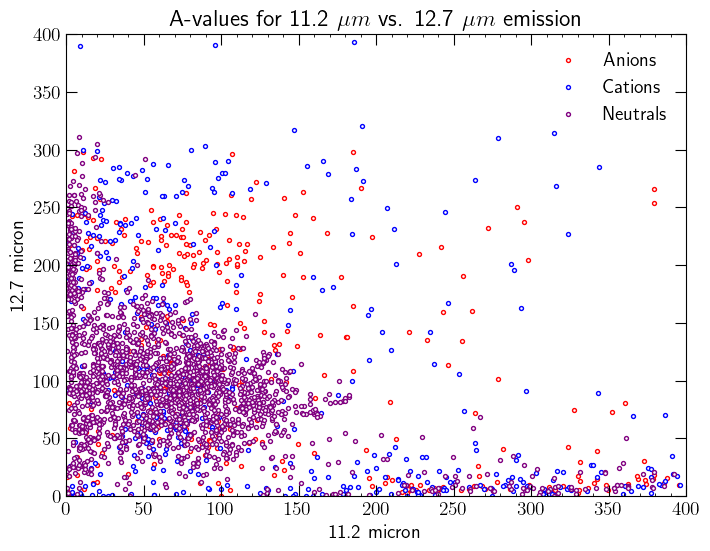

In [21]:
#A scatterplot of two quantitivae features:

plt.scatter(x = df[df["Charge state"] == 'Anion']['$A_{11.2}$'], y =  df[df["Charge state"] == 'Anion']['$A_{12.7}$'], s =8, c='White',
         edgecolors='red', label = "Anions")
plt.scatter(x = df[df["Charge state"] == 'Cation']['$A_{11.2}$'], y =  df[df["Charge state"] == 'Cation']['$A_{12.7}$'], s =8, label = "Cations", c='White',
         edgecolors='blue')
plt.scatter(x = df[df["Charge state"] == 'Neutral']['$A_{11.2}$'], y =  df[df["Charge state"] == 'Neutral']['$A_{12.7}$'], s =8, label = "Neutrals", c='White',
         edgecolors='purple')
plt.xlabel("11.2 micron")
plt.ylabel("12.7 micron")
plt.title("A-values for 11.2 $\mu m$ vs. 12.7 $\mu m$ emission");
plt.legend()
plt.ylim(0,400); #Truncate axes for clear display
plt.xlim(0,400);



No clear distinguishing boundaries.

In [24]:
#Correlation matrix:

corr = df.corr(numeric_only = True)
corr.style.background_gradient()

,Specie_UID,Charge,Size ($N_C$),solos,duos,trios,quartets,$s/N_{H}$,$d/N_{H}$,$t/N_{H}$,$q/N_{H}$,$A_{11.2}$,$A_{12.0}$,$A_{12.7}$,$A_{13.5}$
Specie_UID,1.000000,-0.084751,0.461725,-0.317911,0.096552,0.673007,0.040882,-0.489545,-0.001951,0.585249,-0.065871,0.042784,0.344798,0.213932,0.193409
Charge,-0.084751,1.000000,0.012782,0.074305,0.071295,-0.050681,-0.086958,0.064682,0.055913,-0.058786,-0.081342,-0.036866,-0.017816,-0.064631,-0.088477
Size ($N_C$),0.461725,0.012782,1.000000,0.283832,0.663208,0.548368,-0.422201,-0.151009,0.268440,0.323125,-0.524900,0.172650,0.341939,-0.034025,0.061143
solos,-0.317911,0.074305,0.283832,1.000000,0.160023,-0.391094,-0.282782,0.839089,-0.214633,-0.460161,-0.339752,0.146153,-0.164239,-0.160506,-0.058505
duos,0.096552,0.071295,0.663208,0.160023,1.000000,0.095576,-0.539242,-0.198401,0.835908,-0.097418,-0.578010,0.101130,0.187983,-0.179133,-0.043063
trios,0.673007,-0.050681,0.548368,-0.391094,0.095576,1.000000,-0.324311,-0.559461,-0.021398,0.926863,-0.390184,0.054146,0.412979,0.083852,0.077231
quartets,0.040882,-0.086958,-0.422201,-0.282782,-0.539242,-0.324311,1.000000,-0.070426,-0.366554,-0.297542,0.922894,-0.097409,-0.101182,0.314240,0.159046
$s/N_{H}$,-0.489545,0.064682,-0.151009,0.839089,-0.198401,-0.559461,-0.070426,1.000000,-0.457344,-0.582769,-0.121699,0.074376,-0.294582,-0.143592,-0.094944
$d/N_{H}$,-0.001951,0.055913,0.268440,-0.214633,0.835908,-0.021398,-0.366554,-0.457344,1.000000,-0.137659,-0.350417,0.005555,0.121741,-0.146612,-0.047553
$t/N_{H}$,0.585249,-0.058786,0.323125,-0.460161,-0.097418,0.926863,-0.297542,-0.582769,-0.137659,1.000000,-0.315224,0.006372,0.329157,0.098063,0.064099


>## <span style='color:DarkBlue'> IV. Data Preprocessing:  </span> For Machine Learning Algorithms

>### <span style='color:Purple'> i.  Prepare dataframe of input features and output array of charge class labels:</span> 

In [56]:
#Choosing relevant subset of features from the full dataframe for ML workflow:

df_input = df.iloc[:,[3,10,11,12,13,14,15,16,17]]
df_input

X = df_input
y = df['Charge state'].values.flatten()

X.head()


,Size ($N_C$),$s/N_{H}$,$d/N_{H}$,$t/N_{H}$,$q/N_{H}$,$A_{11.2}$,$A_{12.0}$,$A_{12.7}$,$A_{13.5}$
0,21.0,0.40,0.0,0.2,0.40,23.82,51.15,64.33,49.86
1,21.0,0.40,0.0,0.2,0.40,42.63,45.78,69.65,21.93
2,21.0,0.40,0.0,0.2,0.40,28.94,24.00,111.67,34.15
3,21.0,0.20,0.2,0.4,0.20,3.34,124.73,61.62,10.51
4,21.0,0.25,0.0,0.0,0.75,13.97,85.72,19.71,34.67


>### <span style='color:Purple'> ii. Prepare Training and Test datasets:</span> 

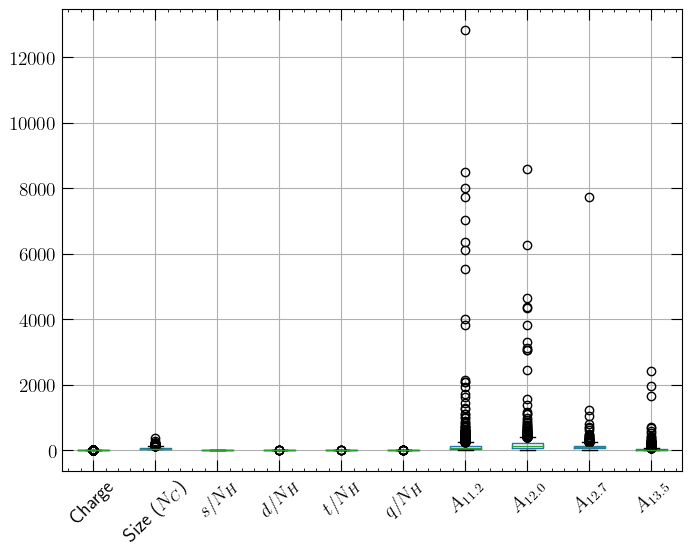

In [25]:
#Examine box plot of features:

df.boxplot(column = cols);
plt.xticks(rotation = 45);
plt.savefig("Plots/DataStats_BoxPlot.png")

Certain features require transformation. 

In [33]:
def get_train_test(X, y, test_size = 0.25, augment = False, random_state = 8):
    
    """ Split the dataframe of input features X and target labels y,
    into random train and test subsets using train_test_split function from scitkit-learn's model selection class.
    Default test_size is 0.25.
    
    Parameters:
    ----------
        X [pandas.DataFrame]: input data of the molecules
        
        y [pandas.DataFrame]: output data i.e. molecular charge state labels ("Neutral", "Cation" or "Anion")
        
        augment [boolean]: Specifies whether or not to augment the training data set 
        
        random_state [int]: Controls the random number generator used for Scikit-learn algorithms. Set to 8.
    
    Returns:
    ----------
        X_train [pandas.DataFrame]: input data to train a classification model on 
        
        X_test [pandas.DataFrame]: input data to test a classification model on 
        
        y_train [numpy.array]: output data to train a classification model for 
        
        y_test [numpy.array]: output data to test a classification model for 
        
        classes [list]: lclass names corresponding to the encoded target values by a LabelEncoder transformer
        
        le : LabelEncoder object used to encode target values 
    """
    
    #Split X and y into random train and test subsets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = test_size, random_state = random_state)
    
    #Encode target labels ["Anion", "Cation", Neutral"] with values 0,1,2, respectively. 
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)
    classes = le.classes_
    
    #If augmenting data is true, then augment the training data. Here oversampling using SMOTE (Synthetic Minority Oversampling TEchnique) 
    #and undersampling using ENN (Edited Nearest Neighbours) is accomplished through using the SMOTEENN function from the Imbalanced-learn library, 
    #which is based on scikit-learn.
    
    if augment == True:
        
        sme = SMOTEENN(random_state=random_state)
        X_train, y_train = sme.fit_resample(X_train, y_train)

    
    return X_train, X_test, y_train, y_test, classes, le


In [34]:
# Train/test sets:
 
# Without augmenting:
X_train, X_test, y_train, y_test, classes, le  = get_train_test(X, y, augment = False)

# With augmenting:
X_train_aug, X_test_aug, y_train_aug, y_test_aug, classes, le  = get_train_test(X, y, augment = True)


In [35]:
#Count class proportions in unaugmented and augmented training datasets:

df_count = pd.DataFrame({'Charge State':['Neutrals', 'Anions', 'Cations'],
                         'Count': [len(y_train[y_train == 2]),len(y_train[y_train == 0]),len(y_train[y_train == 1])]})
df_count

,Charge State,Count
0,Neutrals,1444
1,Anions,320
2,Cations,382


In [36]:
df_count_aug = pd.DataFrame({'Charge State':['Neutrals', 'Anions', 'Cations'],
                         'Count': [len(y_train_aug[y_train_aug == 2]),len(y_train_aug[y_train_aug == 0]),len(y_train_aug[y_train_aug == 1])]})
df_count_aug

,Charge State,Count
0,Neutrals,1240
1,Anions,1255
2,Cations,1194


<AxesSubplot: ylabel='Count'>

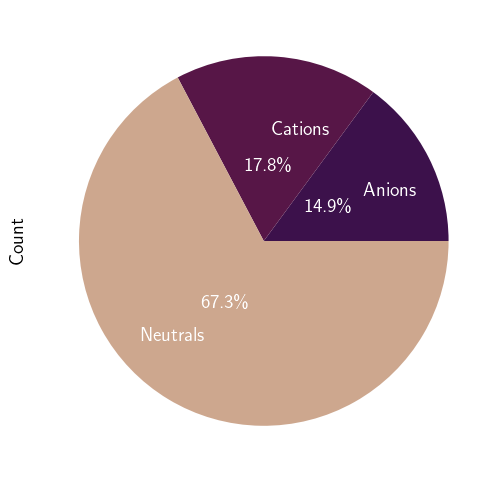

In [39]:
#Plot pie-charts showing proportions of the three classes, before and after augmenting the training dataset. 

random.seed(40)
df_count.groupby(['Charge State']).sum().plot(kind='pie', y='Count',colors = random.sample(get_cmap('twilight').colors, k=3), 
                                             autopct='%.1f\%%', legend=None, pctdistance=0.4, labeldistance = .6,
                                             textprops={'color':"w"})

<AxesSubplot: ylabel='Count'>

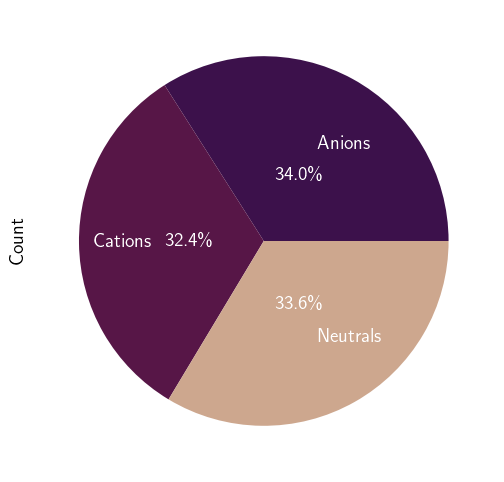

In [41]:
random.seed(40)
df_count_aug.groupby(['Charge State']).sum().plot(kind='pie', y='Count',colors = random.sample(get_cmap('twilight').colors, k=3), 
                                             autopct='%.1f\%%', legend=None, pctdistance=0.4, labeldistance = .6,
                                             textprops={'color':"w"})

>### <span style='color:Purple'> iii. Feature Transformations:</span> 

In [81]:
## Transform selected input features:

def get_transformer():
    
    """Build transformers to transform distributions of certain features to be more normal-like, for better performance of the 
        classification algorithms: 
    
    Parameters:
    ----------
        None
       
    Returns:
    -------
        transformer: A ColumnTransformer object that allows different column subsets of the input data to be transformed separately. 
        Consists of fitted transformers as tuples. 
        
        to_scale [list]: features to be transformed using Standard Scaling. 
        
        to_log [list]: features to be transformed using Power Scaling. 
    """

    #Apply a power transform featurewise to make data more Gaussian-like.
    to_log = ["Size ($N_C$)", '$A_{11.2}$',  '$A_{12.0}$',  '$A_{12.7}$', "$A_{13.5}$"]
    
    #Standardize:
    to_scale = ['$s/N_{H}$', '$d/N_{H}$', '$t/N_{H}$', '$q/N_{H}$'] 

    #Make pipelines of transformers:
    scale_pipe = make_pipeline(StandardScaler())
    log_pipe = make_pipeline(PowerTransformer())

    #Full processor:
    transformer = ColumnTransformer(
                transformers=[
                            ("scale", scale_pipe, to_scale),
                            ("log_transform", log_pipe, to_log)
    ])
    
    return transformer, to_scale, to_log
    

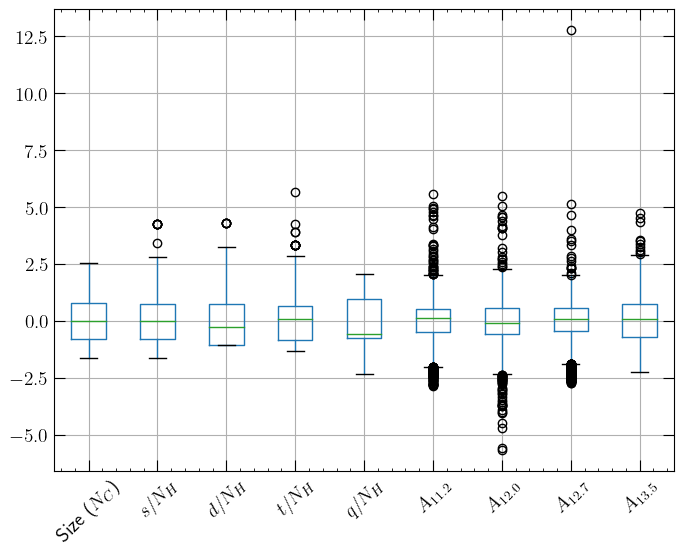

In [47]:
#Examine box plot of features after transformation:

X_transformed= pd.DataFrame(get_transformer()[0].fit_transform(X), columns=cols[1:])
X_transformed.boxplot(column = cols[1:]);
plt.xticks(rotation = 45);
plt.savefig("Plots/DataStats_Transformed_BoxPlot.png")

#### Pre and post-transformation plots on augmented train data:

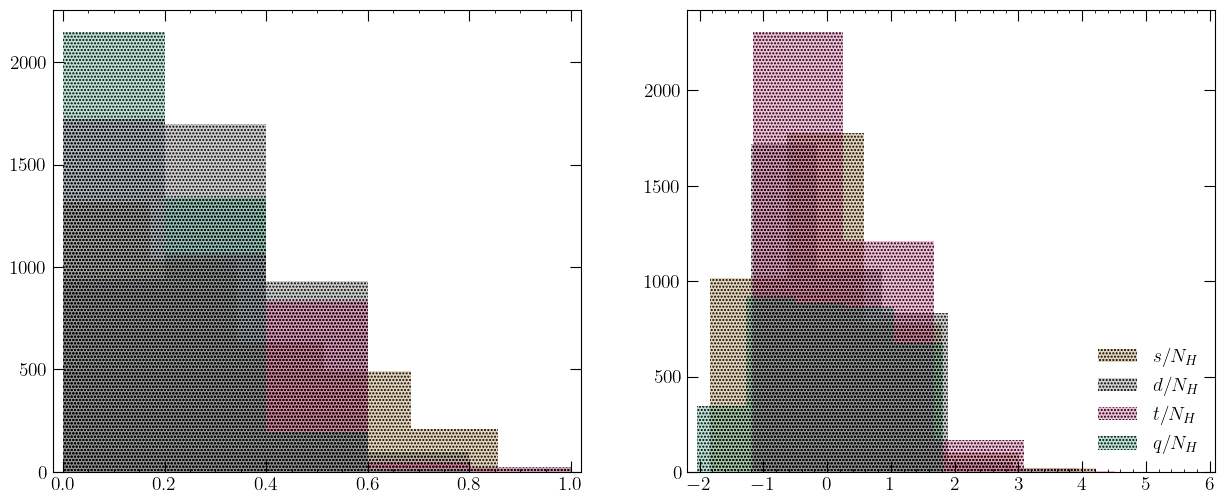

In [51]:
#Transform features in augmented training dataset and examine distributions:

X_train_transformed= get_transformer()[0].fit_transform(X_train_aug)

fig, axs = plt.subplots(1,2, figsize=(15, 6))
alpha = .3
hatch = "....."

to_scale = get_transformer()[1]
to_log = get_transformer()[2]

random.seed(0)
cols1 = random.sample(get_cmap('Dark2').colors, k=4)
cols2 = random.sample(get_cmap('tab20b').colors, k=5)

for (column, col, label) in zip([1,2,3,4],cols1, to_scale):
    axs[0].hist(X_train_aug.iloc[:,column],  alpha=alpha,  color = col, bins = 5, hatch = hatch)

for (column, col, label) in zip([1,2,3,4],cols1, to_scale):
    axs[1].hist(X_train_transformed[:,column],  label = label, alpha=alpha, color = col, bins = 5, hatch = hatch)
    axs[1].legend(frameon=False, loc = "lower right")

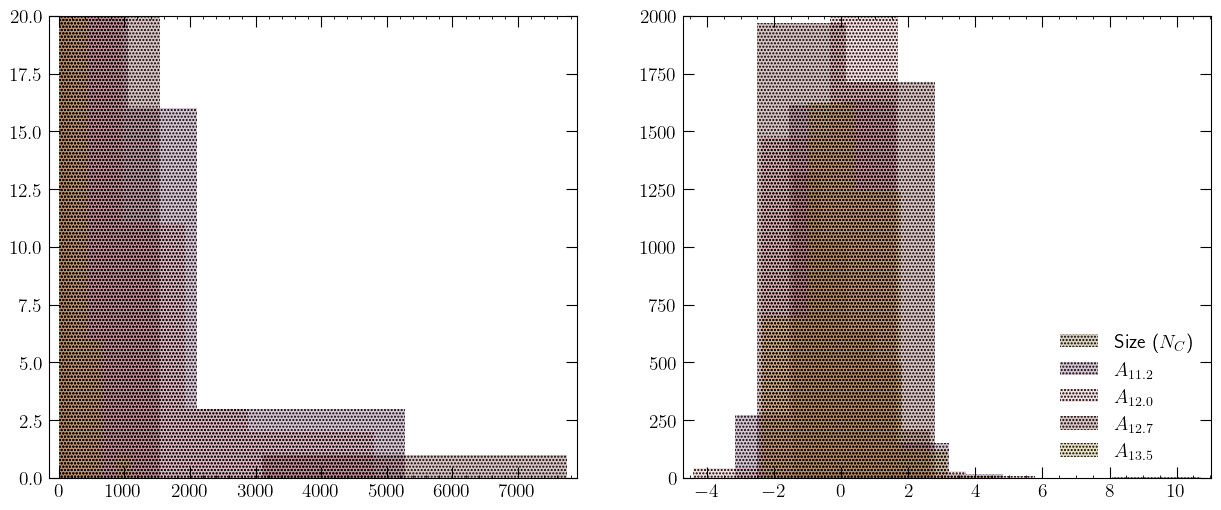

In [52]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))
for (column, col, label) in zip([0,5,6,7,8],cols2, to_log):
    axs[0].hist(X_train_aug.iloc[:,column],  alpha=alpha, color = col, bins = 5,  hatch = hatch)
    axs[0].set_ylim(0,20)
    
for (column, col, label) in zip([0,5,6,7,8],cols2, to_log):
    axs[1].hist(X_train_transformed[:,column],  alpha=alpha,  label = label, color = col, bins = 5,  hatch = hatch)
    axs[1].legend(frameon=False, loc = "lower right")
    axs[1].set_ylim(0,2000)


>## <span style='color:DarkBlue'> V. Model Selection:  </span> Cross-Validation

In [74]:
def build_classifier(clf, X_train, y_train, transformer = get_transformer()[0], random_state=8):
    
    """Construct a classification model and cross-validate it to estimate its effectiveness. 
    
    Parameters:
    ----------
       clf [class]: an sklearn classifier
       
       X_train [pandas.DataFrame]: input data to train a classification model on 
       
       y_train [pandas.DataFrame]: output data to train a classification model for 
               
       transformer: ColumnTransformer object returned by get_transformer() function
       
       random_state [int]: Controls the random number generator used for Scikit-learn algorithms. Set to 8.

       
    Returns:
    -------
        pipeline [class]: Pipeline of transforms with a final estimator
        
        model [class]: Estimator / model
        
        cv_scores [dict]:  Array of scores of the estimator for each run of the cross validation
    """
    
  
    #Build a pipeline with the preprocessor and model:
    pipeline = Pipeline(steps=
                           [('preprocessor', transformer),
                           ('clf', clf)])
                        
    #Fit the pipeline to train the model on the training set:
    model = pipeline.fit(X_train, (y_train))
                        
    #Evaluate metrics by cross-validation on the model:
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=random_state)
                        
    cv_scores = cross_validate(estimator=model,
                               X=X_train,
                               y=y_train,
                               cv=cv,
                               scoring = ["balanced_accuracy", "f1_weighted"],
               return_train_score=True, return_estimator = False)
    
    return pipeline, model, cv_scores
        
    

In [63]:
def plot_CV_results():
    
    """ Construct various classifiers and plot cross-validation scores for comparison to aid with model selection. 
    """
    
    #Obtain train and set data sets without any augmentation to the training set. 
    X_train, X_test, y_train, y_test, classes, le  = get_train_test(X, y, augment = False)

    #Logistic Regression:
    lg_pipeline, lg_clf, lg_scores = build_classifier(LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight = 'balanced'),
                                        X_train = X_train,
                                        y_train = y_train)
        
    #Support Vector Machine:
    svm_pipeline, svm_clf, svm_scores = build_classifier(SVC(kernel ='rbf', decision_function_shape='ovr', class_weight = 'balanced'),
                                          X_train = X_train,
                                          y_train = y_train)
    
    #Decision Tree:
    dt_pipeline, dt_clf, dt_scores = build_classifier(DecisionTreeClassifier(class_weight = 'balanced'),
                                         X_train = X_train,
                                          y_train = y_train)
    
    
    #Random Forest Classifier:
    rf_pipeline, rf_clf, rf_scores = build_classifier(RandomForestClassifier(class_weight = 'balanced'),
                                         X_train = X_train,
                                          y_train = y_train)
    

    #Gradient Boosting Classifier:
    gb_pipeline, gb_clf, gb_scores = build_classifier(GradientBoostingClassifier(), 
                                         X_train = X_train,
                                          y_train = y_train)
    
    
    
    classifiers = ('Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting')
    cv_scores = ['Balanced Accuracy (Train)', 'Balanced Accuracy (Test)', 'Weighted F1 Score (Train)', 'Weighted F1 Score (Test)']
    
    #Store mean and standard deviation of cross-validation scores:
    mean_scores, std_scores = [],[]
    
    for scores in [lg_scores, svm_scores, dt_scores, rf_scores,gb_scores]:
        mean_scores.append([np.mean(scores['train_balanced_accuracy']),
                             np.mean(scores['test_balanced_accuracy']),
                             np.mean(scores['train_f1_weighted']),
                             np.mean(scores['test_f1_weighted'])])
        std_scores.append([np.std(scores['train_balanced_accuracy']),
                             np.std(scores['test_balanced_accuracy']),
                             np.std(scores['train_f1_weighted']),
                             np.std(scores['test_f1_weighted'])])
        
    mean_scores = np.array(mean_scores)
    std_scores = np.array(std_scores)
    
    #Data frame of cross-validation scores:
    df_means = pd.DataFrame(mean_scores, columns=cv_scores, index=classifiers)
    df_err =  pd.DataFrame(std_scores, columns=cv_scores, index=classifiers)
    
    #Present results in a bar plot:
    fig, ax = plt.subplots( figsize =(10,6))
    df_means.plot.bar(color = plt.cm.twilight(np.linspace(0, 1, len(classifiers))), alpha = 0.8, yerr = df_err, capsize=2, ax=ax)
    plt.legend(loc="center right")
    plt.xlim(right=7.5)
    plt.tick_params(
    axis='both',          
    which='both',      
    bottom=True,    
    top=False,  
    right = False,
    labelbottom=True) 
    ax.tick_params(axis='x', labelrotation=30)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.savefig("Plots/CVScores_comparison.pdf", dpi = 200)
    

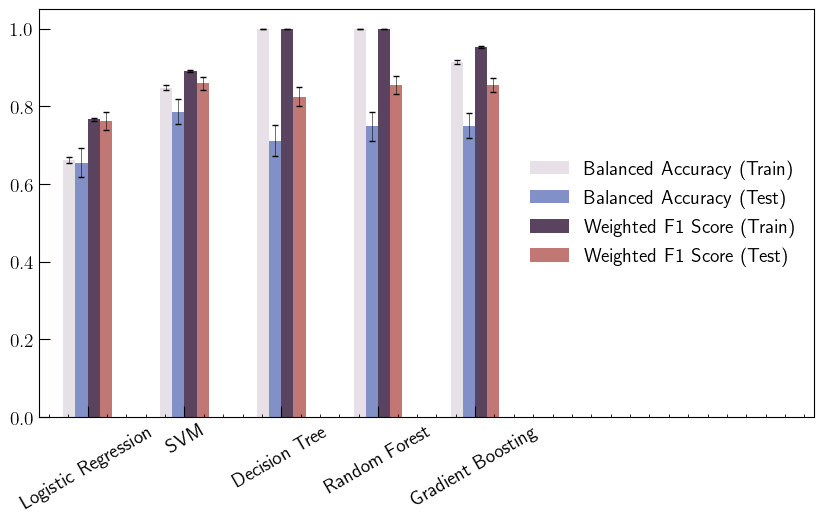

In [64]:
plot_CV_results()

Go with a Random Forest Classifier for optimal performance.

>## <span style='color:DarkBlue'> VI. Model Selection:  </span> Cross-Validation

In [128]:
def tune_RandomForest():
    
    """ Tune the hyperparameters of a Random Forest Classifier by performing an exhaustive cross-validated grid-search over specified 
     parameter values by implementing sklearn's GridSearchCV scheme. 
     
     
     Parameters:
     -------
     None
     
     Returns:
     -------
     GridSearchCV [class]: Result of the grid search, containing the best classifier and its parameters. 
     
     """
    #Build a Random Forest Classifier:
    
    X_train_aug, X_test_aug, y_train_aug, y_test_aug, classes, le  = get_train_test(X, y, augment = True)
    
    rf_pipeline_aug, rf_clf_aug, rf_scores_aug = build_classifier(RandomForestClassifier(),
                                                                  X_train = X_train_aug,
                                                                  y_train = y_train_aug)
    
    
    #Tune hyperparameters the RF Classifier through a Grid Search:
        
    n_estimators = [int(x) for x in np.linspace(start = 100 , stop = 500, num = 10)] # returns 10 numbers 

    max_features = ['sqrt', 'log2', None]

    max_depth = [int(x) for x in np.linspace(10, 100, num = 10)] 

    max_depth.append(None)

    bootstrap = [True, False]

    criterion = ["gini", "entropy"]

    
    param_grid = {"clf__n_estimators": n_estimators,
              "clf__max_depth": max_depth,
              "clf__max_features": max_features,
              "clf__bootstrap": [True, False],
              "clf__criterion": ["gini", "entropy"]}
        
    
    # Run Grid Search:
    grid_search_aug = GridSearchCV(rf_pipeline_aug, param_grid=param_grid,
                                   scoring="accuracy",
                                   n_jobs=-1, return_train_score=True)
    
    start = time()
    grid_search_aug.fit(X_train_aug, y_train_aug)
    print("GridSearchCV took %.2f seconds to complete." % ((time() - start)))
    
    #Results:
    
    print("**** Grid Search Results **** \n")

    print("Best Model: {0}".format(grid_search_aug.best_estimator_["clf"]))
    
    return grid_search_aug


    
    

In [ ]:
grid_search_aug = tune_RandomForest()

In [ ]:
def evaluate_model(grid_search_model):
    
    """ Evaluate performance of the best-tuned Random Forest Classifier by testing on the test data, and 
    inspecting the Classification Report, Confusion Matrix, and Receiver Operating Characteristic Curve. 
    The Feature Importance for the finalized model is also investigated.
     
     
     Parameters:
     -------
     GridSearchCV [class]: Result of the grid search, containing the best classifier and its parameters. 

     
     Returns:
     -------
     None
     
     """
    
    
    #Get predictions for test data using the tuned Random Forest Classifier:
    RF_preds_aug = grid_search_aug.best_estimator_.predict(X_test_aug)
    RF_probs_aug = grid_search_aug.best_estimator_.predict_proba(X_test_aug)
    
    
    #Overall metrics:
    
    print("**** Metrics ****\n")
    # Overall metrics
    print("Test Accuracy:",grid_search_aug.best_estimator_.score(X_test_aug, y_test_aug))
    print("Overall Accuracy:",accuracy_score(y_test_aug, RF_preds_aug))
    print("Overall Precision:",precision_score(y_test_aug, RF_preds_aug, average='weighted'))
    print("Overall Recall:",recall_score(y_test_aug, RF_preds_aug, average='weighted'))
    print("F-Score: {0}\n".format(f1_score(y_test_aug, RF_preds_aug, average='weighted')))

    #Classification Report:
    print("**** Classification Report **** \n")
    print(classification_report(y_test_aug, RF_preds_aug, target_names = le.classes_))
    
    #Confusion Matrix:
    print("**** Confusion Marix **** \n")
    cmp = ConfusionMatrixDisplay.from_estimator(grid_search_aug.best_estimator_, X = X_test_aug, y=y_test_aug,display_labels=le.classes_,
                                            cmap = plt.cm.magma_r, normalize="true")
    plt.savefig("Plots/CM.png")
    plt.show()

    print("**** ROC Curve **** \n")

    #ROC (Receiver Operating Characteristic) Curve:
    charge_classes = le.classes_
          
    # Get ROC metrics for each class
    fpr = {}
    tpr = {}
    thresh ={}
    random.seed(40)
    colors = random.sample(get_cmap('twilight').colors, k=3) 

    for i in range(len(charge_classes)):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test_aug, RF_probs_aug[:,i], pos_label=i)
    
    # Plot the ROC chart
    plt.plot(fpr[0], tpr[0], label=le.classes_[0] + ' vs Rest', c = colors[0], lw = 2.)
    plt.plot(fpr[1], tpr[1], label=le.classes_[1] + ' vs Rest',  c = colors[1], lw = 2.)
    plt.plot(fpr[2], tpr[2], label=le.classes_[2] + ' vs Rest',  c = colors[2], lw = 2.)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best', frameon = False)
    plt.savefig("Plots/ROCCurve.pdf")

    
    macro_roc_auc_ovr = roc_auc_score(
    y_test_aug,
    RF_probs_aug,
    multi_class="ovr",
    average="weighted",
)
    
    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")
    plt.show()
     
          
    #Feature Importance:
    feature_names = X.columns
    perm_imp_rf_aug = permutation_importance(grid_search_aug.best_estimator_, X_test_aug, y_test_aug, n_repeats=10, random_state=8)
    perm_forest_importances_aug = pd.Series(perm_imp_rf_aug.importances_mean, index=feature_names)
          
          
    print("**** Feature Importance  **** \n")
    fig, ax = plt.subplots()
    perm_forest_importances_aug.plot.bar(yerr=perm_imp_rf_aug.importances_std, ax=ax, color = colors[1], capsize=2)
    ax.set_ylabel("Mean Accuracy Decrease")
    fig.tight_layout()
    plt.tick_params(
        axis='both',          
        which='both',      
        bottom=True,    
        top=False,  
        right = False,
        labelbottom=True) 
    
    ax.tick_params(axis='x', labelrotation=30)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.savefig("Plots/FeatureImp.pdf", dpi = 200)
    
    

**** Metrics ****

Test Accuracy: 0.8701117318435754
Overall Accuracy: 0.8701117318435754
Overall Precision: 0.8786397779492745
Overall Recall: 0.8701117318435754
F-Score: 0.8735774549195692

**** Classification Report **** 

              precision    recall  f1-score   support

       Anion       0.71      0.73      0.72       106
      Cation       0.66      0.75      0.70       128
     Neutral       0.97      0.93      0.95       482

    accuracy                           0.87       716
   macro avg       0.78      0.80      0.79       716
weighted avg       0.88      0.87      0.87       716

**** Confusion Marix **** 



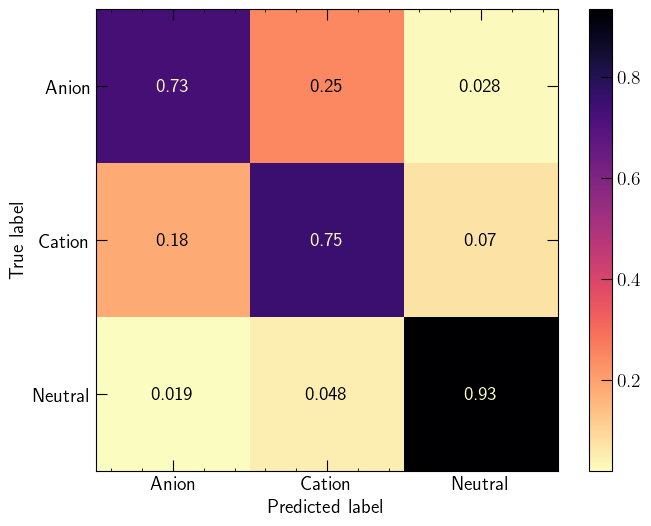

**** ROC Curve **** 

Macro-averaged One-vs-Rest ROC AUC score:
0.96


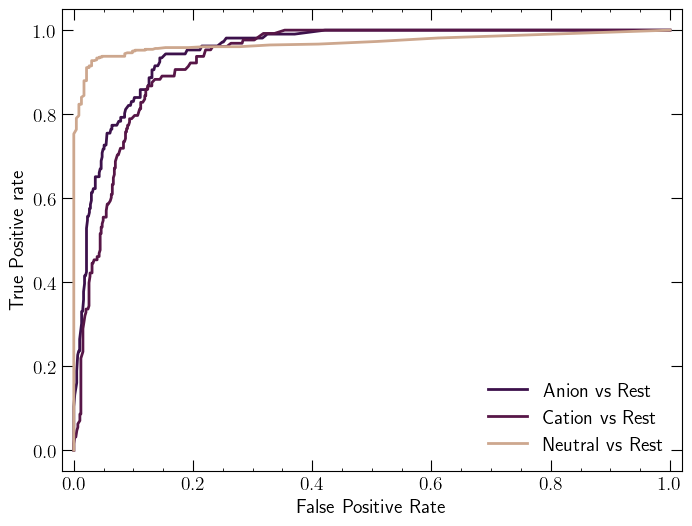

**** Feature Importance  **** 



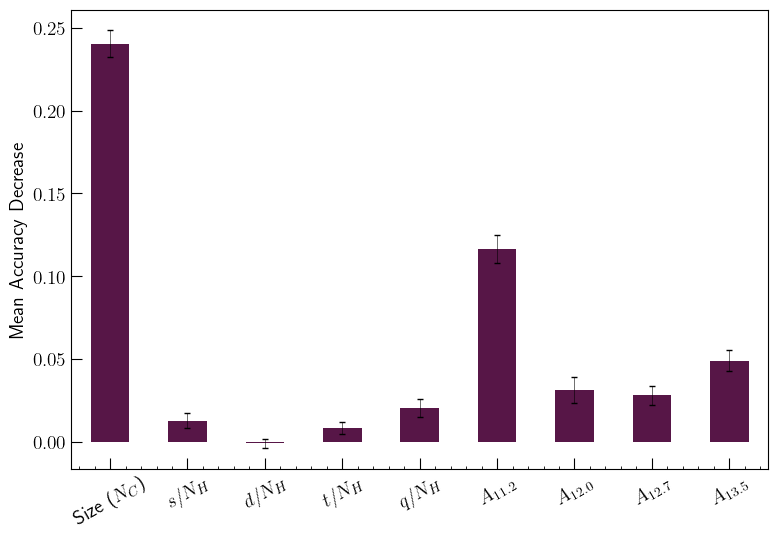

In [127]:
evaluate_model(grid_search_aug)